* changed by nov05 on 2024-04-16  

# Setup a game

In [1]:
from ConnectN import ConnectN
game_setting = {'size':(3,3), 'N':3} ## board size, winning condition
game = ConnectN(**game_setting)

In [2]:
game.move((0,1))
print(game.state)
print(game.player)
print(game.score)

[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
-1
None


In [3]:
# player -1 move
game.move((0,0))
# player +1 move
game.move((1,1))
# player -1 move
game.move((1,0))
# player +1 move
game.move((2,1))

print(game.state)
print(game.player)
print(game.score)

[[-1.  1.  0.]
 [-1.  1.  0.]
 [ 0.  1.  0.]]
1
1


# Play a game interactively

<IPython.core.display.Javascript object>


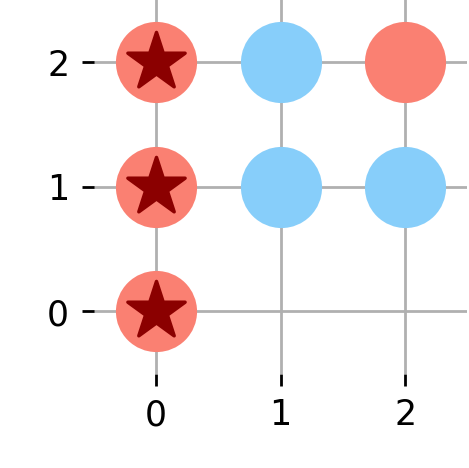

In [12]:
%matplotlib notebook
from Play import Play
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)
## remember to click on the "power" button when finish
## or other games can't be played

# Initialize an AI to play the game
We need to define a policy for tic-tac-toe, that takes the game state as input, and outputs a policy and a critic

## Tentative Exercise:
Code up your own policy for training   

```Python
Policy_solution(
  (conv): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (fc): Linear(in_features=64, out_features=32, bias=True)
  (fc_action1): Linear(in_features=32, out_features=16, bias=True)
  (fc_action2): Linear(in_features=16, out_features=9, bias=True)
  (fc_value1): Linear(in_features=32, out_features=8, bias=True)
  (fc_value2): Linear(in_features=8, out_features=1, bias=True)
  (tanh_value): Tanh()
)
```

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import *
import numpy as np
import random


class Policy_solution(nn.Module):
    def __init__(self):
        super(Policy_solution, self).__init__()
        # solution
        self.conv = nn.Conv2d(1, 16, kernel_size=2, stride=1, bias=False)
        self.size = 2*2*16
        self.fc = nn.Linear(self.size,32)

        # layers for the policy
        self.fc_action1 = nn.Linear(32, 16)
        self.fc_action2 = nn.Linear(16, 9)
        
        # layers for the critic
        self.fc_value1 = nn.Linear(32, 8)
        self.fc_value2 = nn.Linear(8, 1)
        self.tanh_value = nn.Tanh()
                
    def forward(self, x):  ## x~torch.Size([1, 1, 3, 3])
        # solution
        y = F.relu(self.conv(x))
        y = y.view(-1, self.size)
        y = F.relu(self.fc(y))
        
        # the action head
        # locations where actions are not possible, we set the prob to zero
        a = F.relu(self.fc_action1(y))
        a = self.fc_action2(a)  ## torch.Size([1, 9])
        max_a = torch.max(a)
        # availability of moves
        avail = (torch.abs(x.squeeze())!=1).type(torch.FloatTensor)  ## torch.Size([3, 3])
        avail = avail.reshape(-1, 9)  ## torch.Size([1, 9])
        # subtract off max for numerical stability (avoids blowing up at infinity)
        exp = avail * torch.exp(a-max_a)  ## torch.Size([1, 9])
        prob = exp / torch.sum(exp)
        
        # the value head
        value = F.relu(self.fc_value1(y))
        value = self.tanh_value(self.fc_value2(value))
        return prob.view(3,3), value  ## action probs, V-value
        

class Policy(nn.Module):
    def __init__(self,
                 action_dim=(3,3),  ## same with board_dim
                 conv_out_channels=16,
                 linear_out_features=32,
                 actor_hidden_dim=[16],
                 critic_hidden_dim=[8],
                 activation_fn=nn.LeakyReLU,):
        super(Policy, self).__init__()
        self.action_dim = action_dim
        self.action_size = np.prod(action_dim)
        linear_in_features = 2*2*conv_out_channels
        self.common_layers = nn.ModuleList([nn.Conv2d(1, conv_out_channels, kernel_size=2, stride=1, bias=False),
                                            nn.Flatten(),
                                            nn.Linear(linear_in_features, linear_out_features), 
                                            activation_fn()])
        self.actor_layers = nn.ModuleList()
        num_layers = len(actor_hidden_dim)+1
        for i,(in_features,out_features) in enumerate(zip([linear_out_features]+actor_hidden_dim, 
                                                          actor_hidden_dim+[self.action_size])):
            self.actor_layers.append(nn.Linear(in_features, out_features))
            if i!=num_layers-1:
                self.actor_layers.append(activation_fn())
            else:  ## last layer
                pass
        self.critic_layers = nn.ModuleList()
        num_layers = len(critic_hidden_dim)+1
        for i,(in_features,out_features) in enumerate(zip([linear_out_features]+critic_hidden_dim, 
                                                          critic_hidden_dim+[1])):
            self.critic_layers.append(nn.Linear(in_features, out_features))
            if i!=num_layers-1:
                self.critic_layers.append(activation_fn())
            else:  ## last layer
                self.critic_layers.append(nn.Tanh())
                
    def forward(self, x):  ## x~torch.Size([1, 1, board_width, board_height])
#         y = x.clone().detach()
        y = x
        for layer in self.common_layers:
            y = layer(y)
        a,v = y,y
        for layer in self.actor_layers:
            a = layer(a)
        a_max = torch.max(a)
        a_exp = ((torch.abs(x.squeeze())!=1).type(torch.FloatTensor)
                 .reshape(-1, self.action_size)
                 * torch.exp(a-a_max))
        a_probs = a_exp / torch.sum(a_exp)  ## action probabilities
        for layer in self.critic_layers:
            v = layer(v) 
        return a_probs.reshape(*self.action_dim), v 
    
    
# policy = Policy_solution()
policy = Policy()
print(policy)

Policy(
  (common_layers): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (actor_layers): ModuleList(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=9, bias=True)
  )
  (critic_layers): ModuleList(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Tanh()
  )
)


## Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature

This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$. 

In [51]:
import MCTS
from copy import copy
import random

def Policy_Player_MCTS(game):
    mytree = MCTS.Node(copy(game))
    for _ in range(50):
        mytree.explore(policy)
   
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1) 
    return mytreenext.game.last_move

def Random_Player(game):
    return random.choice(game.available_moves())    

In [52]:
game = ConnectN(**game_setting)
print("game state:\n", game.state)
Policy_Player_MCTS(game)

game state:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


(1, 0)

# Play a game against the policy

<IPython.core.display.Javascript object>


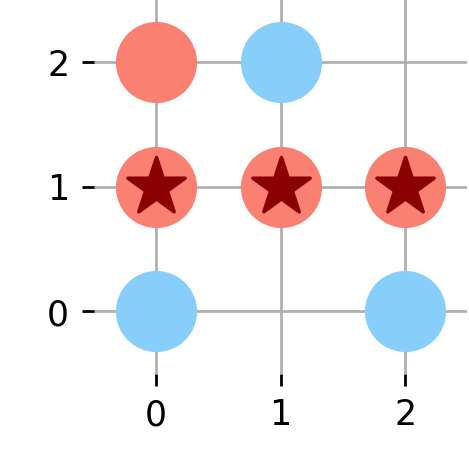

In [46]:
%matplotlib notebook
from Play import Play
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)
## remember to click on the "power" button when finish
## or other games can't be played

# Training Loop  
⚠️ AlphaZero uses a linear combination of both actor and critic losses, then back-propagating both at the same time. I'm not sure if it would perform better to do it for the actor and critic separately, or if DDPG would be even better.  

In [65]:
# initialize our alphazero agent and optimizer
import torch.optim as optim
game = ConnectN(**game_setting)
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=.01, weight_decay=1.e-4)

## Tenative exercise:
code up the alphazero loss function, defined to be
$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 
I added a constant term $\sum_t \sum_a p^{(t)}\log p^{(t)}$ so that when $v_\theta^{(t)} = z$ and $p^{(t)}_a = \pi_\theta(a|s_t)$, $L=0$, this way we can have some metric of progress.

In [68]:
# train our agent
from collections import deque
import MCTS

episodes = 400
outcomes = []
losses = []

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

for e in range(episodes):
    mytree = MCTS.Node(ConnectN(**game_setting))
    vterm = []
    logterm = []
    
    while mytree.outcome is None:
        for _ in range(50):
            mytree.explore(policy)
            
        current_player = mytree.game.player
        mytree, (v, nn_v, p, nn_p) = mytree.next()        
        mytree.detach_mother()
        
        # solution
        # compute prob* log pi 
        loglist = torch.log(nn_p)*p
        # constant term to make sure if policy result = MCTS result, loss = 0
        constant = torch.where(p>0, p*torch.log(p),torch.tensor(0.))
        logterm.append(-torch.sum(loglist-constant))
        vterm.append(nn_v*current_player)
        
    # we compute the "policy_loss" for computing gradient
    outcome = mytree.outcome
    outcomes.append(outcome)
    
    ## solution
    loss = torch.sum( (torch.stack(vterm)-outcome)**2 + torch.stack(logterm) )
    optimizer.zero_grad()

    loss.backward()
    losses.append(float(loss))
    optimizer.step()
    
    if (e+1)%50==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    timer.update(e+1)
    
timer.finish()

D:\Users\guido\miniconda3\envs\drlnd_py310\lib\site-packages\torch\autograd\__init__.py:266: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


game:  50 , mean loss: 6.57 , recent outcomes:  [1, -1, 1, 0, 0, 1, 1, 0, 1, 1]


game:  100 , mean loss: 5.52 , recent outcomes:  [0, 1, 0, 0, 0, 1, 0, 1, 1, 0]


game:  150 , mean loss: 5.24 , recent outcomes:  [0, 1, 0, 0, -1, 1, -1, 1, 0, 0]


game:  200 , mean loss: 2.68 , recent outcomes:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 1]


game:  250 , mean loss: 1.51 , recent outcomes:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


game:  300 , mean loss: 3.55 , recent outcomes:  [0, -1, 0, 0, 0, 0, 0, 0, 0, 0]


game:  350 , mean loss: 1.74 , recent outcomes:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


game:  400 , mean loss: 1.13 , recent outcomes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<IPython.core.display.Javascript object>


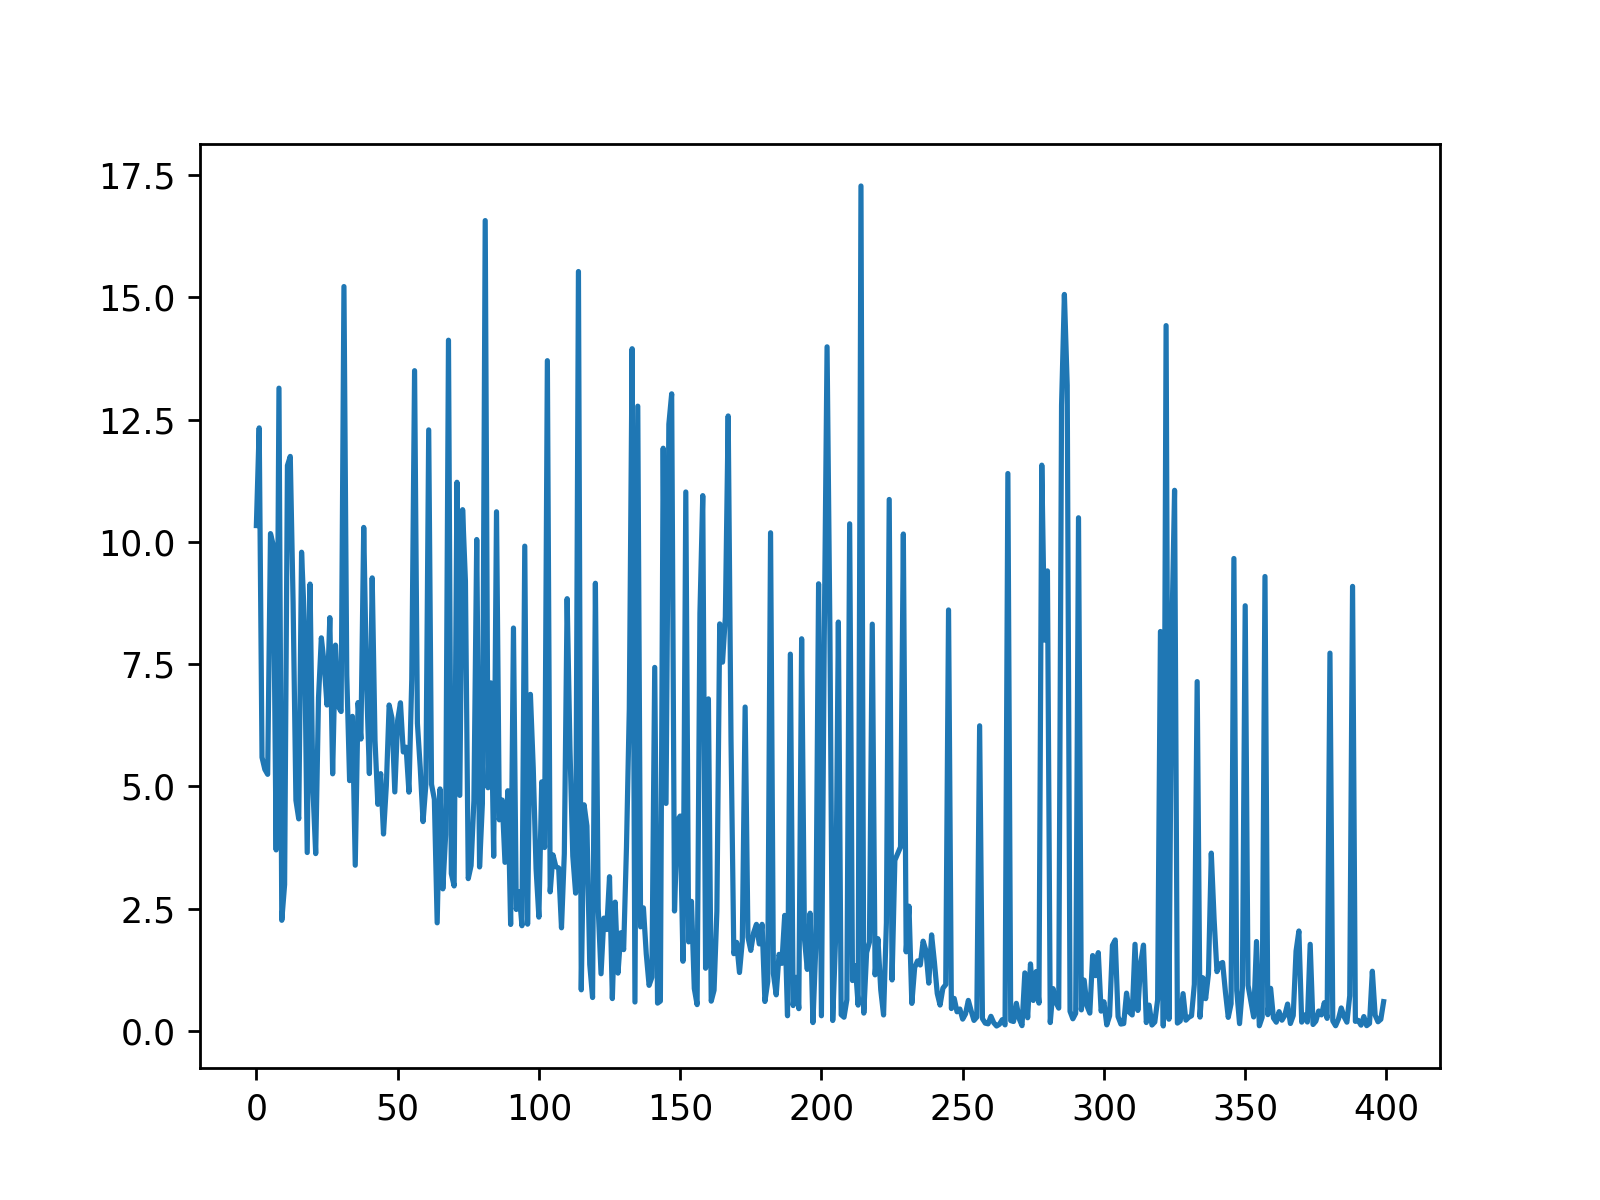

In [69]:
# plot your losses
import matplotlib.pyplot as plt
%matplotlib notebook
plt.plot(losses)
plt.show()

# Play a game against your alphazero agent !

<IPython.core.display.Javascript object>


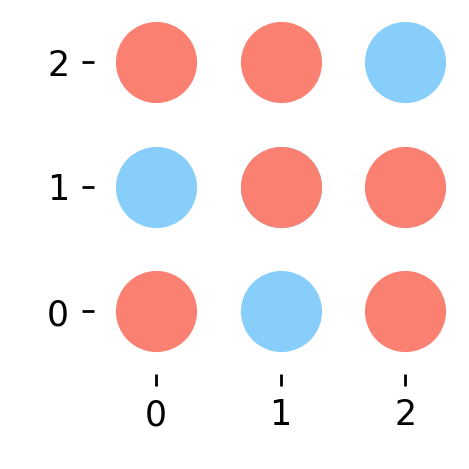

In [70]:
%matplotlib notebook
# as first player
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)

<IPython.core.display.Javascript object>


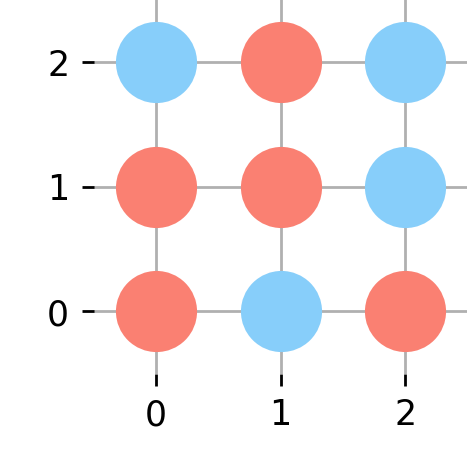

In [72]:
%matplotlib notebook
# as second player
gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)